## Import libraries

In [1]:
import numpy as np
import pandas as pd
from scipy.special import gamma, factorial
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

**The Simulation of $R_{+}$-indexed Karlin Stable processes has two parts, the small-jump part and large-jump part**

### Small-jump part
This part contains two functions:  
1. sample_fBm(n, H)
   - Input:
      - n: the number of points on interval $[0, 1]$
      - H: Hurst parameter
   - Output: 
      - fBm on $[0, 1]$

### Large-jump part:
This part contains two functions:
1. sample_one_oov(n, beta)
   - Input:
      - n: the number of points on interval $[0, 1]$
      - beta: $\beta \in (0, 1)$  
   - Output:
      - one copy of odd-occupancy vector from indicator method

      
2. R1_large_jump(n, alpha, beta)
   - Input:
      - n: the number of points on interval $[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$ 
   - Output:
      - Y2: the large-jump part

**Once the simulations of small-jump part and large-jump part completed separately, we combine them to obtain the $R_{+}$-indexed Karlin stable processes and produce some plots**
1. R1_KSP(n, alpha, beta)
   - Input:
      - n: the number of points on interval $[0, 1]$
      - alpha: $\alpha \in (0, 2)$
      - beta: $\beta \in (0, 1)$ 
   - Output:
      - Y1+Y2: combined of small and large jumps

In [2]:
def sample_fBm(n, H):
    s, k = np.zeros(2*(n-1)), np.linspace(0, 2*(n-1)-1, 2*(n-1))
    s = (abs((k-1)/n)**(2*H) - 2*(k/n)**(2*H) + ((k+1)/n)**(2*H))/2
    S = np.concatenate((s[0:(n-1)], s[n-1], s[(n-2):0:-1]), axis=None)
    S_tilde = np.fft.fft(S)
    
    x_1, x_2 = np.random.normal(0, 1, 2*(n-1)), np.random.normal(0, 1, 2*(n-1))
    x = [ np.complex(x_1[i], x_2[i]) for i in range(0, 2*(n-1)) ] 
    y = np.fft.fft(np.sqrt(S_tilde)*x)
    y1 = (1/np.sqrt(2*(n-1)))*y.real
    Y1 = np.zeros(n+1)
    Y1[0], Y1[1:(n+2)] = 0, np.cumsum(y1[0:n])
    return Y1

def sample_one_oov(n, beta):
    ## generate the random parameter Lambda first.
    ga_1, ga_beta, ga_1beta = np.random.gamma(1, 1), np.random.gamma(beta, 1), np.random.gamma(1-beta, 1)
    Lambda = ga_1*ga_1beta/ga_beta

    t = np.linspace(0, 1, n+1)
    uu = np.random.uniform(0, 1)
    ind1 = np.where(t<uu, 0, 1)
    proba = 0.5*(1-np.exp(-2*(1/n)*Lambda))
    ind2 = np.random.binomial(1, proba, n+1)
    return (ind1+ind2.cumsum()) % 2


def R1_large_jump(N, n, alpha, beta, epsilon):
    ## sampling N iid layers
    D = np.zeros((n+1, N))
    for i in range(0,N):
        D[:,i] = sample_one_oov(n, beta)

    U = np.random.uniform(0, 1, N)
    V = np.random.choice([-1, 1], N, replace=True, p=[0.5, 0.5])*(epsilon/(U**(1/alpha))) 
    return np.sum(D*V, axis=1)
        
def R1_KSP(n, alpha, beta):
    if alpha == 1:
        C_alpha = np.pi/2
    else:
        C_alpha = (1-alpha)/(gamma(2-alpha)*np.cos(np.pi*alpha/2))
    if alpha >= 1:
        epsilon = (0.01*(3-alpha)*np.sqrt(alpha*C_alpha)/(2-alpha)**(3/2))**(2/alpha)     # error from B-E < 0.01
    else:
        epsilon = 0.0001
    sigma_epsilon = (np.sqrt(alpha*C_alpha/(2-alpha))**(1/2))*epsilon**(1-alpha/2)
    nu_epsilon = 2**(1-beta)*C_alpha*epsilon**(-alpha)
    N = int(np.random.poisson(nu_epsilon, 1))
    
    Y1 = sigma_epsilon*sample_fBm(n, beta/2)
    Y2 = R1_large_jump(N, n, alpha, beta, epsilon=epsilon)
    return Y1, Y2, Y1+Y2

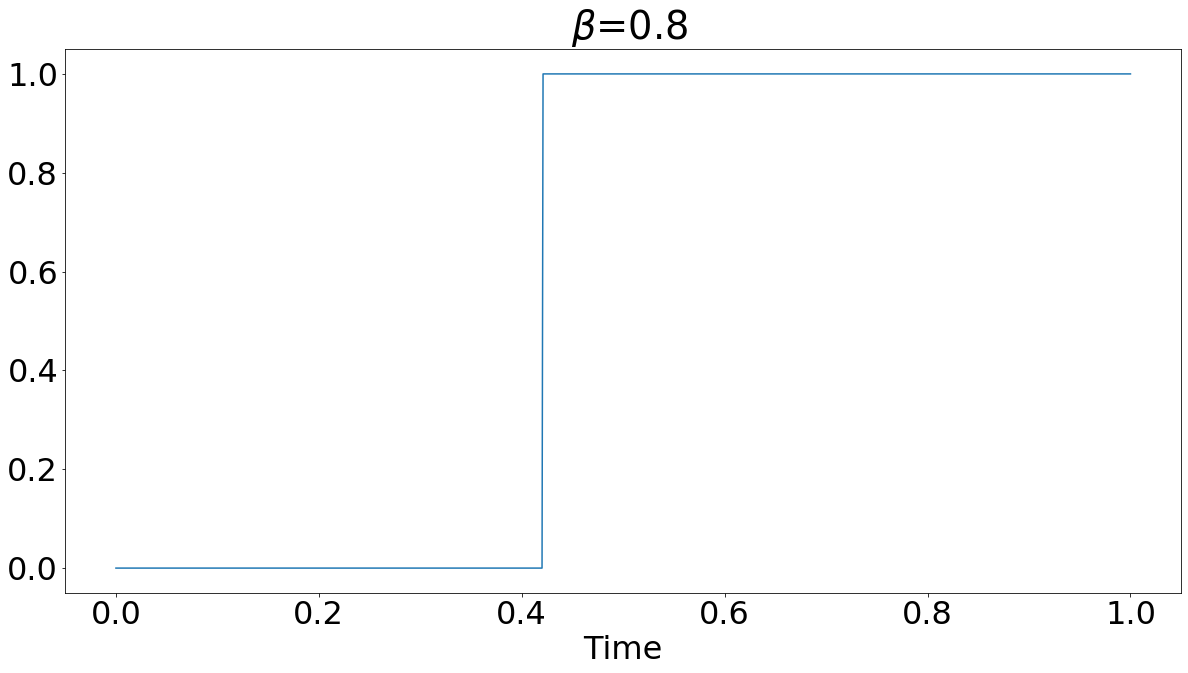

In [11]:
import matplotlib.pyplot as plt

## generate a sample of OOV

beta = 0.8
n = 1000

t = np.linspace(0,1,n+1)
D = sample_one_oov(n,beta)

plt.figure(figsize=(20,10))
plt.plot(t, D)
plt.xlabel("Time")
plt.rc('font', size=32)
plt.title(r" $\beta$=" + str(beta))
#plt.savefig('KSP_OOV_'+str(beta)[0]+str(beta)[2]+'.pdf')  
plt.show()


## Plots

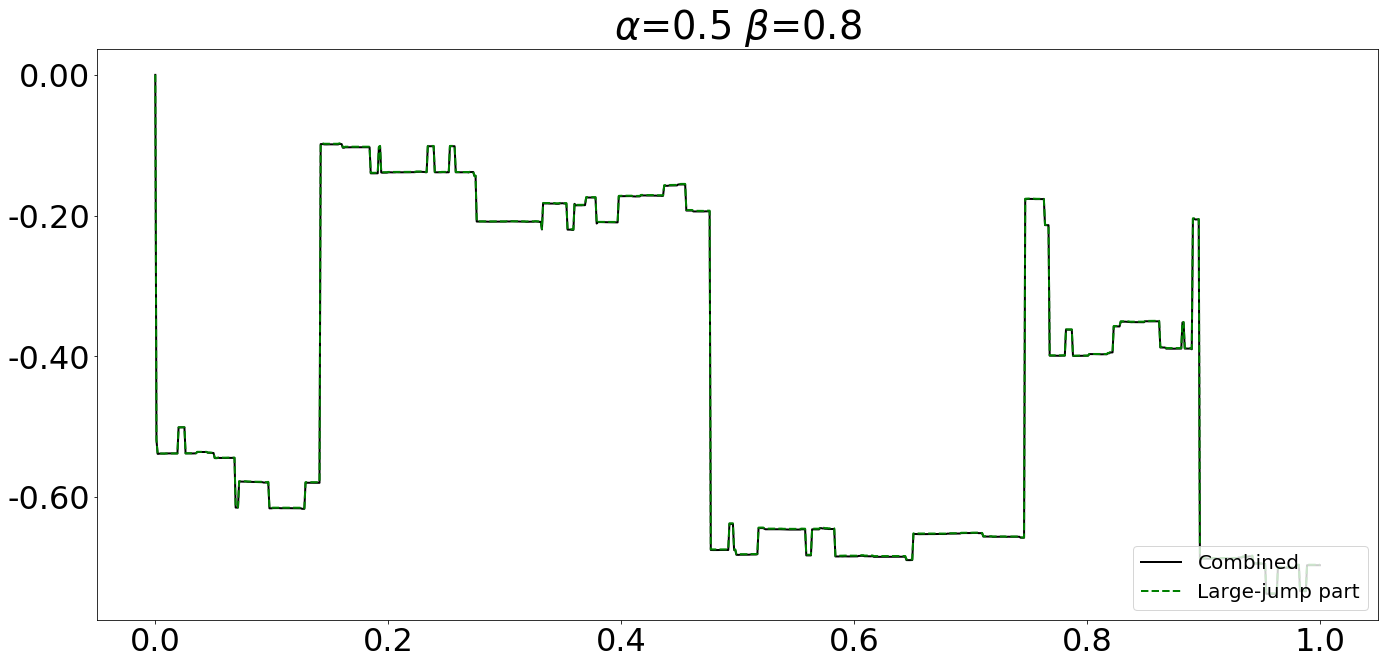

In [12]:
## YZ: here is the ready-to-run codes for our plots
## I removed the functions for plotting. Let the users decide how they want to plot the processes.

n = 1000
alpha = 0.5
beta = 0.8


t = np.linspace(0, 1, n+1)
Y1, Y2, Y = R1_KSP(n, alpha, beta)

plt.figure(figsize = (20, 10))
plt.plot(t, Y, '-', color = 'black', label = 'Combined', linewidth = 2)
plt.plot(t, Y2, '--', color='green', label='Large-jump part', linewidth = 2)
plt.legend(loc = 'lower right', prop={'size': 20})
##plt.xlabel("Time") 
plt.xlabel("")
plt.ylabel("")
plt.rc('font', size=32)
plt.title(r"$\alpha$=" + str(alpha) + r" $\beta$=" + str(beta))
plt.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%.2f" % x))
plt.tight_layout()
#plt.savefig('KSP_alpha_'+str(alpha)+'_beta_'+str(beta)+'_compare.pdf')
plt.show()


## Plot with different parameters

In [83]:
n = 600
alpha1 = 1.3
alpha2 = 1.8
beta1, beta2, beta3 = 0.2, 0.5, 0.8

Y11, Y21, Y1 = R1_KSP(n, alpha1, beta1)
Y12, Y22, Y2 = R1_KSP(n, alpha1, beta2)
Y13, Y23, Y3 = R1_KSP(n, alpha1, beta3)
Y14, Y24, Y4 = R1_KSP(n, alpha2, beta1)
Y15, Y25, Y5 = R1_KSP(n, alpha2, beta2)
Y16, Y26, Y6 = R1_KSP(n, alpha2, beta3)

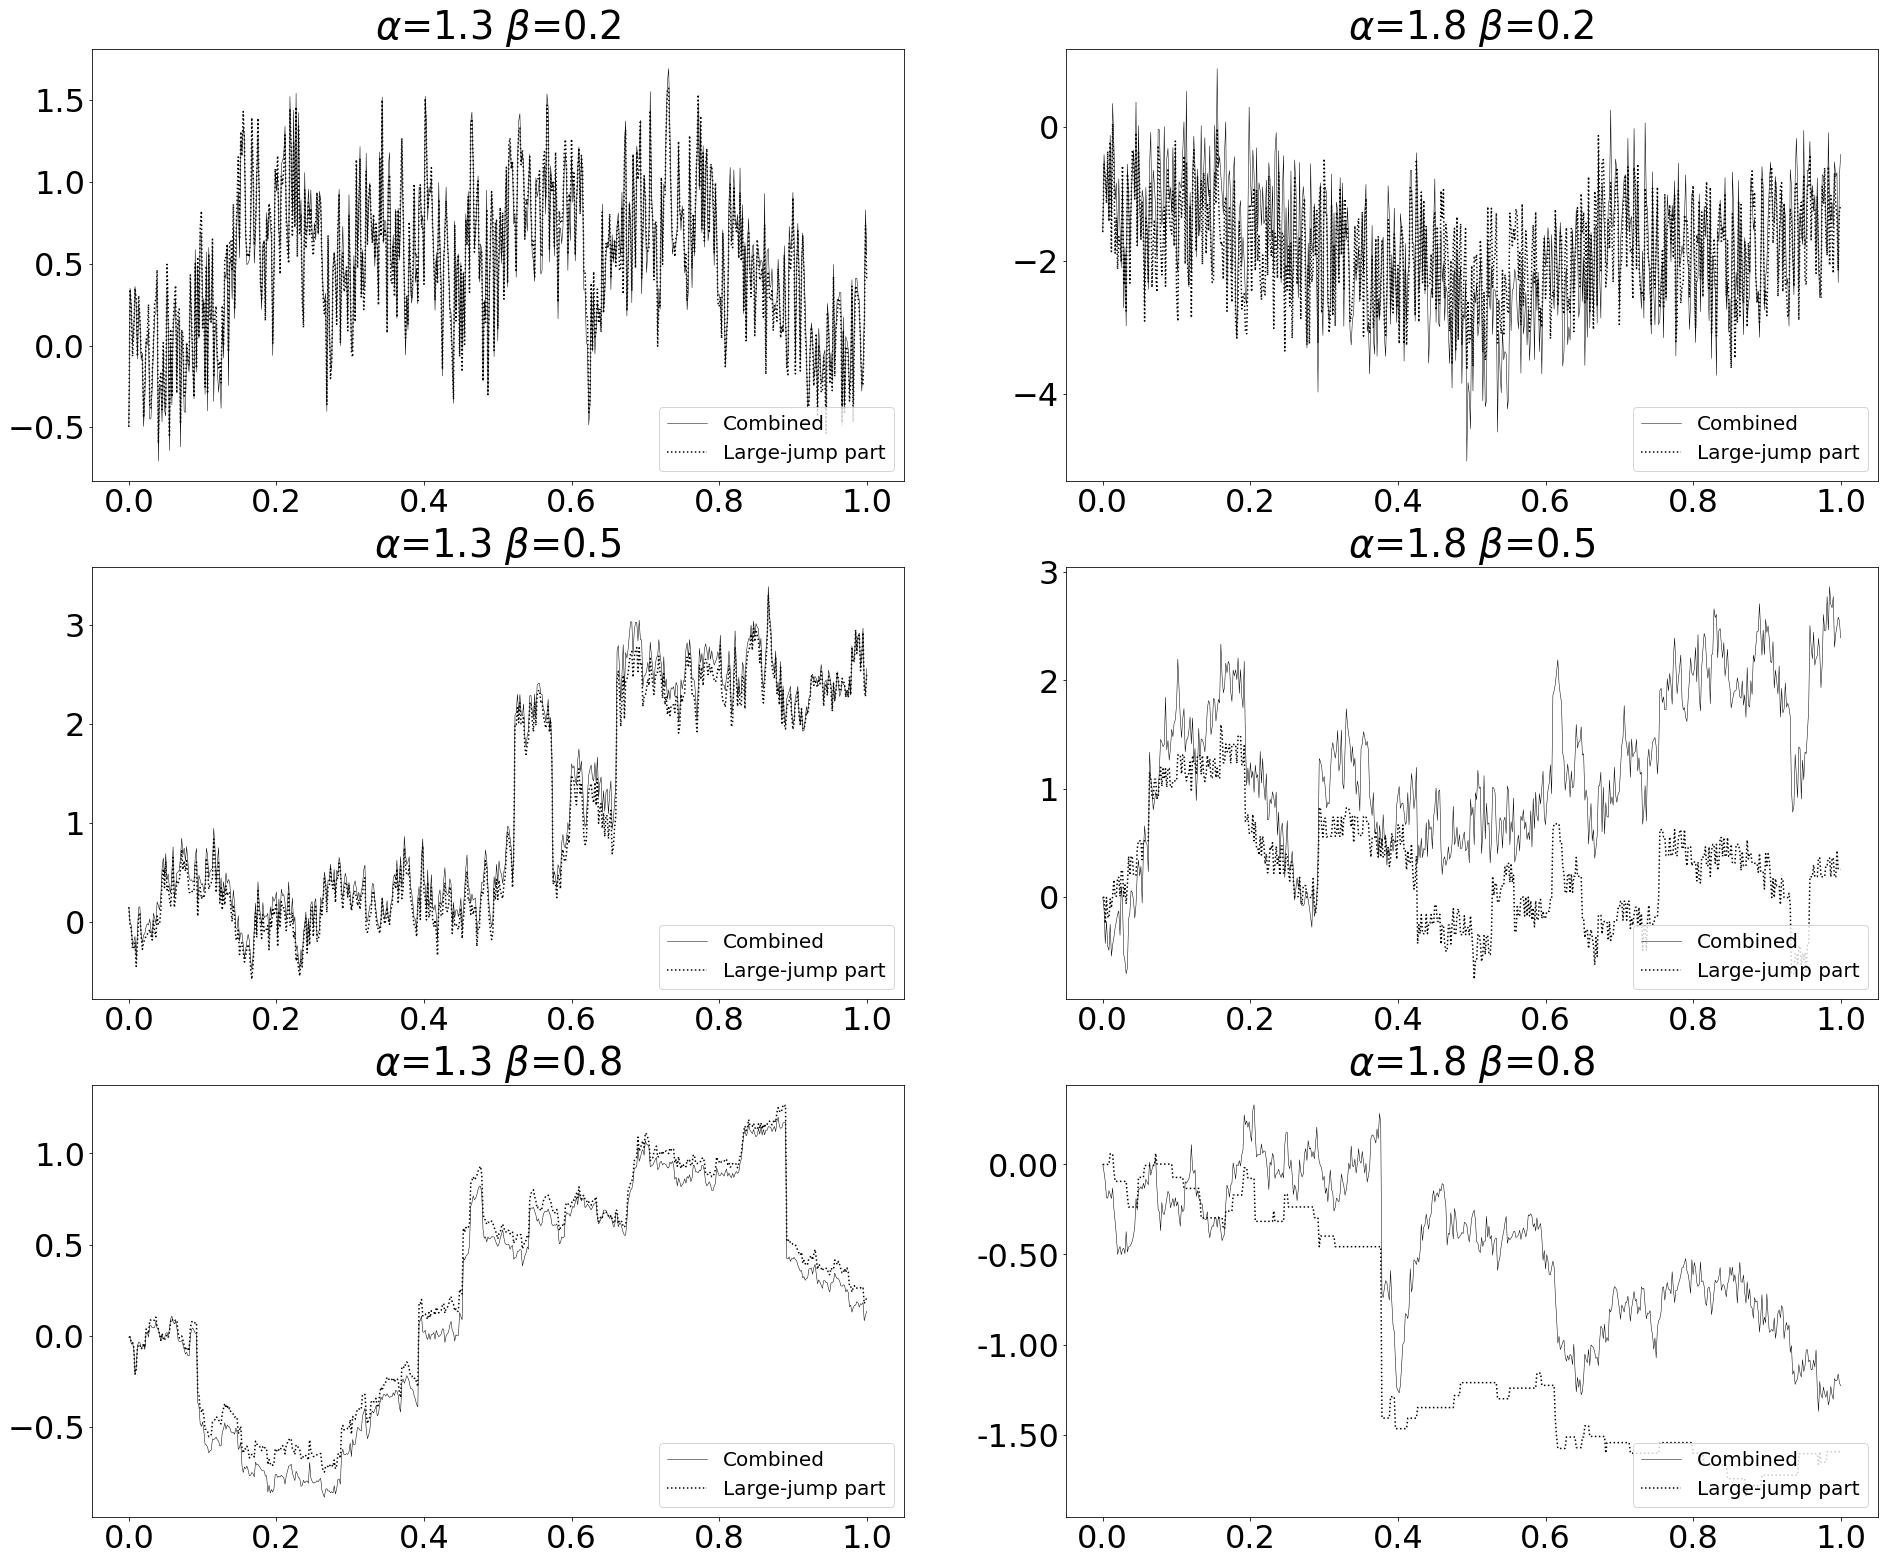

In [84]:
t = np.linspace(0, 1, n+1)

C1 = 'black'
C2 = 'black'

fig, axs = plt.subplots(3, 2, figsize=(32, 27), sharey=False, sharex = False)
plt.subplots_adjust(wspace = 0.2)

LW = 0.5
LW2 = 1.5

axs[0,0].plot(t, Y1, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[0,0].plot(t, Y21, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[0,0].legend(loc = 'lower right', prop={'size': 20})
axs[0,0].set_title(r"$\alpha$=" + str(alpha1) + r" $\beta$=" + str(beta1))

axs[1,0].plot(t, Y2, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[1,0].plot(t, Y22, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[1,0].legend(loc = 'lower right', prop={'size': 20})
axs[1,0].set_title(r"$\alpha$="  + str(alpha1)+ r" $\beta$=" + str(beta2))

axs[2,0].plot(t, Y3, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[2,0].plot(t, Y23, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[2,0].legend(loc = 'lower right', prop={'size': 20})
axs[2,0].set_title(r"$\alpha$="  + str(alpha1) + r" $\beta$=" + str(beta3))

axs[0,1].plot(t, Y4, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[0,1].plot(t, Y24, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[0,1].legend(loc = 'lower right', prop={'size': 20})
axs[0,1].set_title(r"$\alpha$=" + str(alpha2) + r" $\beta$=" + str(beta1))

axs[1,1].plot(t, Y5, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[1,1].plot(t, Y25, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[1,1].legend(loc = 'lower right', prop={'size': 20})
axs[1,1].set_title(r"$\alpha$=" + str(alpha2) + r" $\beta$=" + str(beta2))

axs[2,1].plot(t, Y6, '-', color = 'black', label = 'Combined', linewidth = LW)
axs[2,1].plot(t, Y26, ':', color=C2, label='Large-jump part', linewidth = LW2)
axs[2,1].legend(loc = 'lower right', prop={'size': 20})
axs[2,1].set_title(r"$\alpha$="  + str(alpha2) + r" $\beta$=" + str(beta3))

plt.rc('font', size=32)
fig.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%.2f" % x))

plt.savefig('Figure4.pdf', bbox_inches = 'tight')

plt.show()

### Fractional Brownian Motions

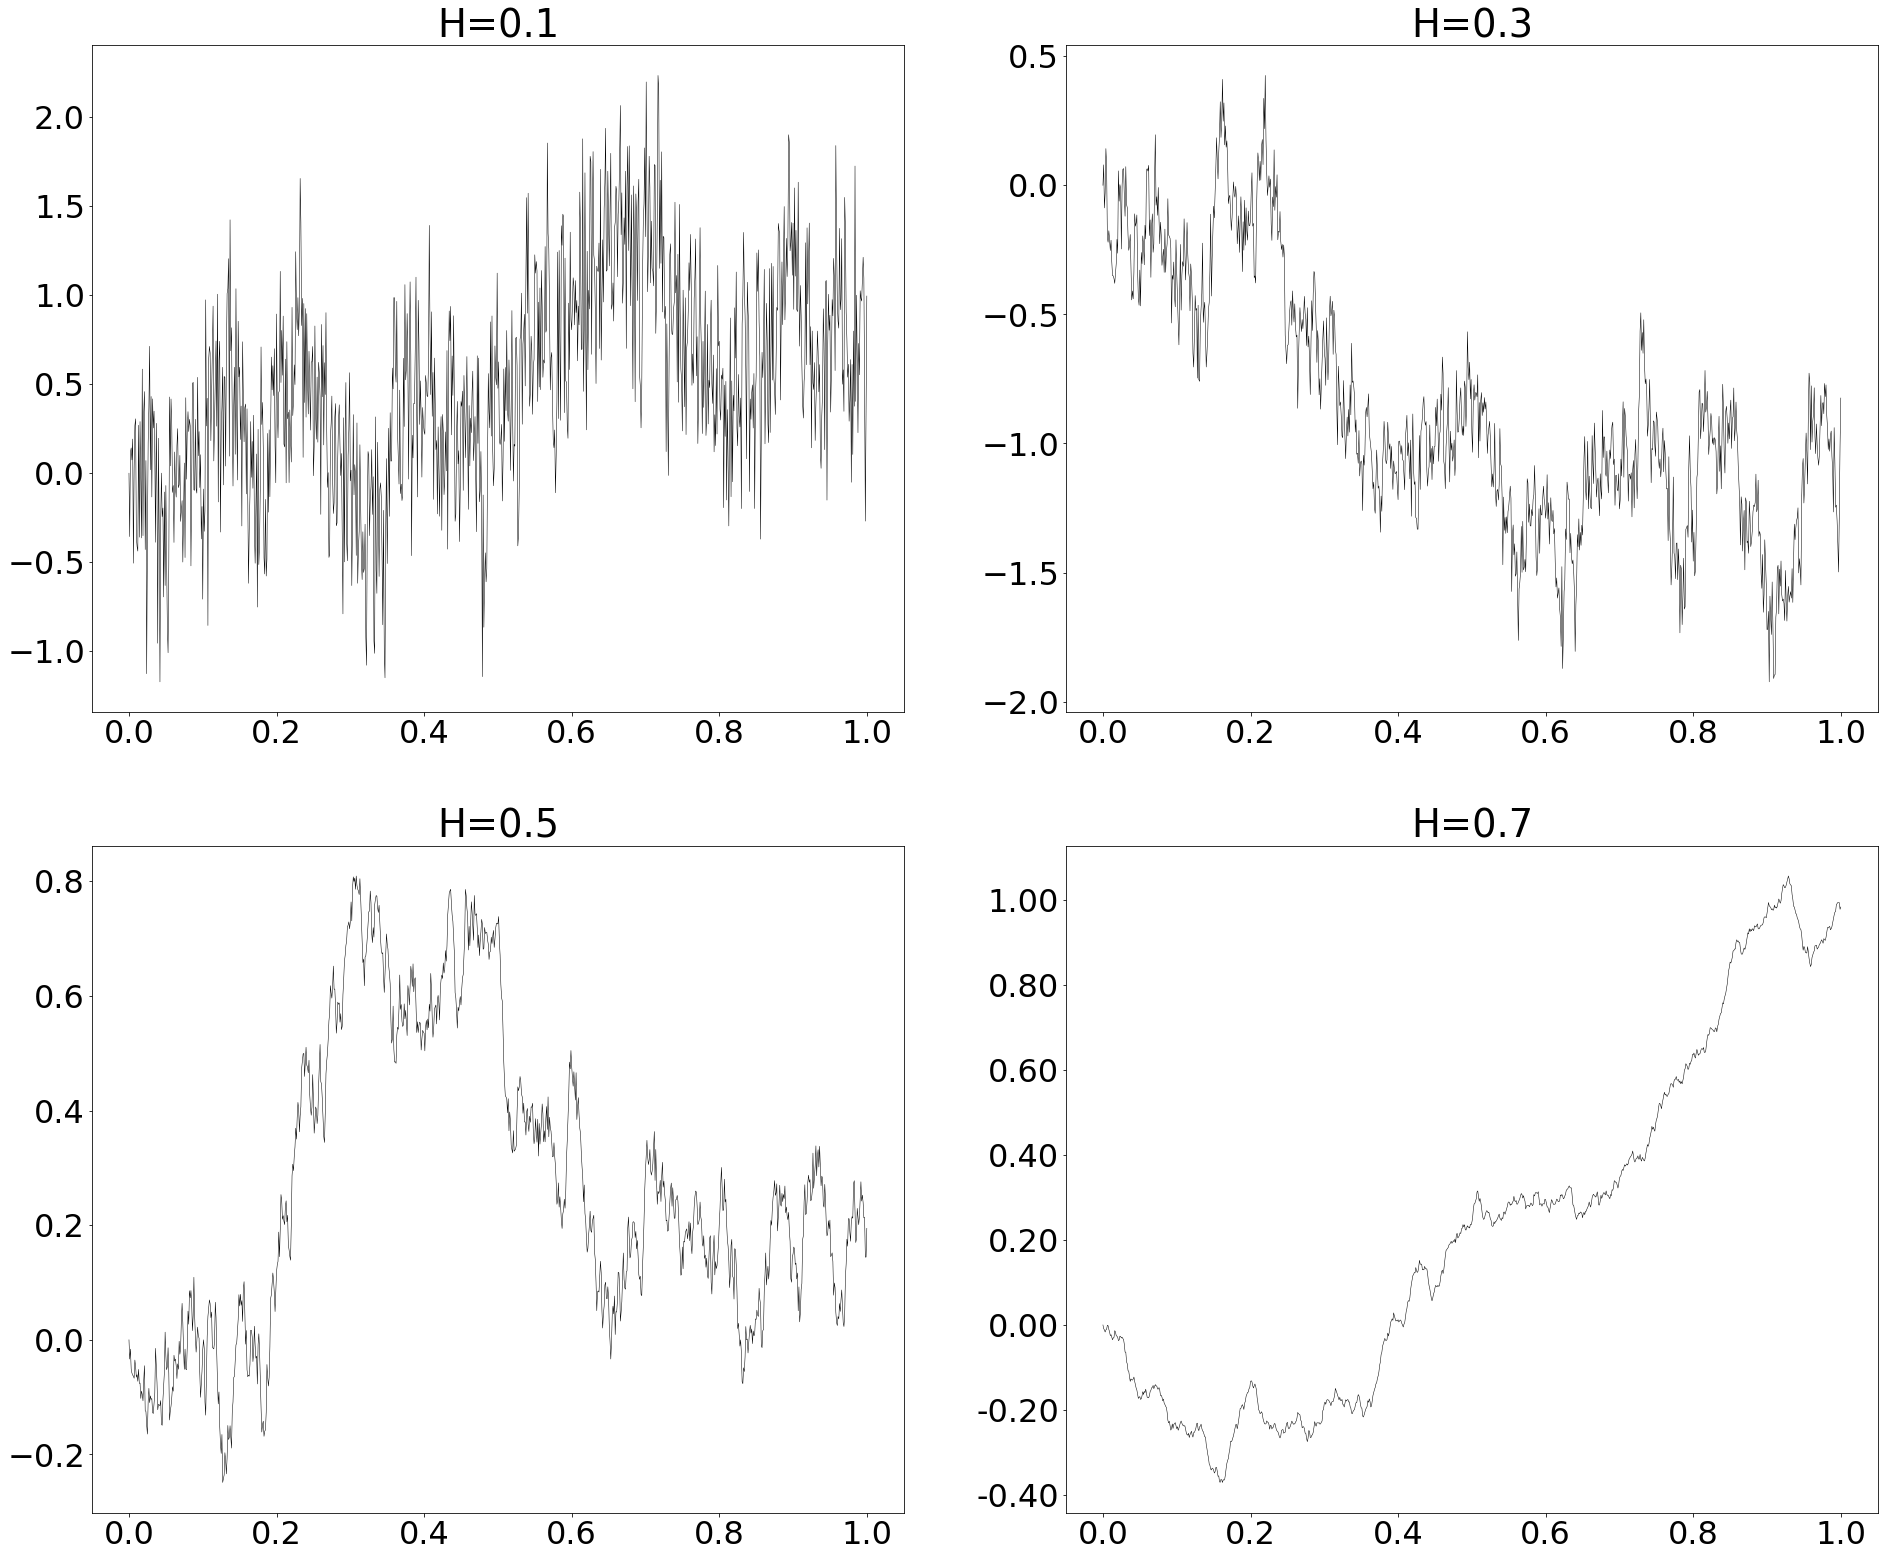

In [5]:
n = 1000

Y1 = sample_fBm(n, 0.1)
Y2 = sample_fBm(n, 0.3)
Y3 = sample_fBm(n, 0.5)
Y4 = sample_fBm(n, 0.7)

t = np.linspace(0, 1, n+1)


fig, axs = plt.subplots(2, 2, figsize=(32, 27), sharey=False, sharex = False)
plt.subplots_adjust(wspace = 0.2)

LW = 0.5
LW2 = 1.5

axs[0,0].plot(t, Y1, color = 'black', linewidth = LW)
axs[0,0].set_title("H=0.1")

axs[0,1].plot(t, Y2, color = 'black', linewidth = LW)
axs[0,1].set_title("H=0.3")

axs[1,0].plot(t, Y3, color = 'black', linewidth = LW)
axs[1,0].set_title("H=0.5")

axs[1,1].plot(t, Y4, color = 'black', linewidth = LW)
axs[1,1].set_title("H=0.7")


plt.rc('font', size=32)
fig.gca().yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, p: "%.2f" % x))

plt.savefig('fbm.pdf', bbox_inches = 'tight')

plt.show()